# COMP551: Project 3

#### Group 47
#### Authors : Ying Sun, Said Khalifef & Boury Mbodj
#### Date : March 16th 2019
#### Subject: The given file contains the implementation of a vgg13-bn supervised classification model using pytorch. 

In [0]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist"

Model		Project3_model.ipynb   test_images.pkl	 vgg19_bn.ipynb
P3resnet.ipynb	Project3_model.py      train_images.pkl
P3trial2.ipynb	sample_submission.csv  train_labels.csv
P3trial4.ipynb	solution_final3.csv    Untitled.ipynb


In [0]:
f=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_images.pkl","rb")
f1=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_labels.csv","rb")
f2=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/test_images.pkl","rb")

In [0]:
#read training data through pandas
x_train=pd.read_pickle(f)
#normalize training data by toTensor and mean(0.5) and std(0.5). 
#Note that torchvision.transforms can be used. But I'm still not familiar with it...
x_train=(x_train/255-0.5)*2
#read training lable, the first column in y_train_r is id num, the second column is lable.
y_train_r = pd.read_csv(f1)
#tranfer numpy to tensor, in order to use gpu
y_train=torch.tensor(y_train_r.values[:,1])
#product train set.
trainset=[np.zeros((64,64)),np.zeros(1)]
for j in range(36000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    trainset.append([x_train[j],y_train[j]])
del trainset[0]
del trainset[0]
#copy 1 channel as 3 channels
# Use validation set 
validset=[np.zeros((64,64)),np.zeros(1)]
for j in range(40000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    if (j>36000):
       validset.append([x_train[j],y_train[j]])
del validset[0]
del validset[0]
#copy 1 channel as 3 channels 
for i in range(len(trainset)):
    trainset[i][0]=torch.tensor([np.array(trainset[i][0]),np.array(trainset[i][0]),np.array(trainset[i][0])])
#Get trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
#copy 1 channel as 3 channels 
for i in range(len(validset)):
    validset[i][0]=torch.tensor([np.array(validset[i][0]),np.array(validset[i][0]),np.array(validset[i][0])])
#Get validloader
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
# Preprocessing testset:
x_test=pd.read_pickle(f2)
x_test=(x_test/255-0.5)*2
testset=[np.zeros((64,64)),np.zeros(1)]
for j in range(len(x_test)):
    testset.append([x_test[j],y_train[j]])
del testset[0]
del testset[0]
for i in range(len(testset)):
    testset[i][0]=torch.tensor([np.array(testset[i][0]),np.array(testset[i][0]),np.array(testset[i][0])])
#preporcessing testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [7]:
print('[Train  and validation size]')
print(' - Numpy Shape:', x_train.shape)
print('[Test size]')
print(' - Numpy Shape:', x_test.shape)




[Train  and validation size]
 - Numpy Shape: (40000, 64, 64)
[Test size]
 - Numpy Shape: (10000, 64, 64)


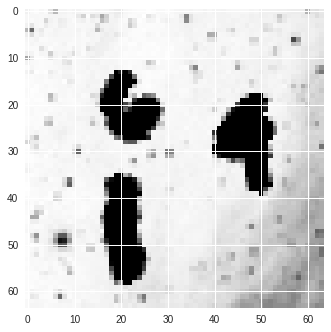

In [8]:
# function to show figures. This part has nothing to do with training.
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_test[100])
plt.show()

In [9]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.vgg13_bn(pretrained = True)
#import OrderedDicted to corectly align the network layers
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs
classifier= nn.Sequential(
                          nn.Dropout(p = 0.5),
                          nn.Linear(in_features=25088, out_features=512, bias=True),
                          nn.BatchNorm1d(512),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p = 0.5),
                          nn.Linear(in_features=512, out_features=102, bias=True),
                          nn.BatchNorm1d(102),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p = 0.4),
                          nn.Linear(102, 10),
        )
#replace the model's classifier with this new classifier 
model.classifier = classifier

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.torch/models/vgg13_bn-abd245e5.pth
532246301it [00:06, 81943793.22it/s]


In [10]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/4
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/4
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [15]:
import time
start_time = time.time()
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.requires_grad = False
# define number of epochs
epochs = 20 
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))
    print("--- %s seconds ---" % (time.time() - start_time))

1
Epoch: 1 Train Loss : 6.2235  Train Accuracy: 0.4875
Epoch: 1 Validation Loss : 2.0810  Validation Accuracy 0.8770
--- 381.6341598033905 seconds ---
2
Epoch: 2 Train Loss : 3.2429  Train Accuracy: 0.7740
Epoch: 2 Validation Loss : 1.2370  Validation Accuracy 0.9320
--- 751.7591245174408 seconds ---
3
Epoch: 3 Train Loss : 2.4176  Train Accuracy: 0.8326
Epoch: 3 Validation Loss : 1.0058  Validation Accuracy 0.9477
--- 1122.4084601402283 seconds ---
4
Epoch: 4 Train Loss : 1.9071  Train Accuracy: 0.8715
Epoch: 4 Validation Loss : 0.8311  Validation Accuracy 0.9445
--- 1492.8043925762177 seconds ---
5
Epoch: 5 Train Loss : 1.6310  Train Accuracy: 0.8925
Epoch: 5 Validation Loss : 0.7335  Validation Accuracy 0.9530
--- 1863.0178892612457 seconds ---
6
Epoch: 6 Train Loss : 1.3135  Train Accuracy: 0.9124
Epoch: 6 Validation Loss : 0.6438  Validation Accuracy 0.9583
--- 2233.948269844055 seconds ---
7
Epoch: 7 Train Loss : 1.1877  Train Accuracy: 0.9215
Epoch: 7 Validation Loss : 0.5563  V

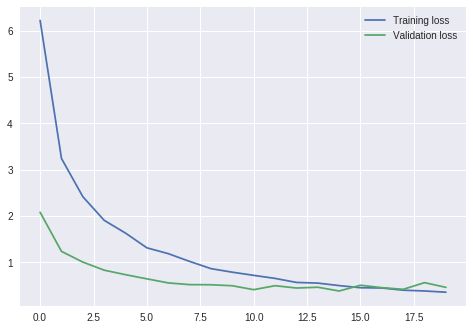

In [16]:
#Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

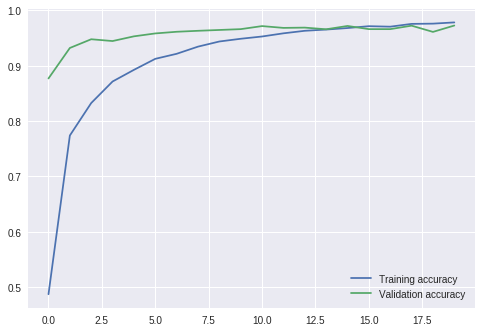

In [17]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [18]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset      loss
  0       1   train  6.223489
  1       2   train  3.242885
  2       3   train  2.417629
  3       4   train  1.907091
  4       5   train  1.631005
  5       6   train  1.313538
  6       7   train  1.187743
  7       8   train  1.020453
  8       9   train  0.864283
  9      10   train  0.787564
  10     11   train  0.719210
  11     12   train  0.653485
  12     13   train  0.566532
  13     14   train  0.552001
  14     15   train  0.498275
  15     16   train  0.451978
  16     17   train  0.446511
  17     18   train  0.399008
  18     19   train  0.382380
  19     20   train  0.355406
  20      1   valid  2.080998
  21      2   valid  1.236994
  22      3   valid  1.005847
  23      4   valid  0.831112
  24      5   valid  0.733535
  25      6   valid  0.643846
  26      7   valid  0.556297
  27      8   valid  0.519060
  28      9   valid  0.516633
  29     10   valid  0.494775
  30     11   valid  0.410127
  31     12   valid  0.495876
  32     13   valid  0.445925
  33     14   valid  0.462833
  34     15   valid  0.381611
  35     16   valid  0.505665
  36     17   valid  0.453638
  37     18   valid  0.417831
  38     19   valid  0.562057
  39     20   valid  0.459904,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})

In [0]:
#get prediction result for test data
predict=test(model,testloader, criteria, 1)
result=predict.numpy()

In [0]:
# Put data in the appropriate format for kaggle submissiom
submission = pd.DataFrame()

In [0]:
a = result.astype(int)
df1 = pd.DataFrame({'Id': a})

In [22]:
submission['Id']=range(0, len(df1) )

submission['Category']=a
submission.head()

,Id,Category
0,0,7
1,1,1
2,2,6
3,3,1
4,4,8


In [0]:
submission.to_csv('vgg19_.csv', index=False)

In [0]:
from google.colab import files
files.download('vgg19_.csv') 